# Loading and Preparing Data
Purpose: Load predictions from different meta-learners and prepare the data for analysis.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

# Load the CSV files
slearner_data = pd.read_csv('../results/s_predictions.csv')
tlearner_data = pd.read_csv('../results/t_predictions.csv')
xlearner_data = pd.read_csv('../results/x_predictions.csv')
rlearner_data = pd.read_csv('../results/r_predictions.csv')

# Add a learner identifier column
slearner_data['Learner'] = 'S-Learner'
tlearner_data['Learner'] = 'T-Learner'
rlearner_data['Learner'] = 'R-Learner'
xlearner_data['Learner'] = 'X-Learner'

# Combine all data into one DataFrame
combined_data = pd.concat([slearner_data, tlearner_data, rlearner_data, xlearner_data], ignore_index=True)

# Calculating CATE for Each Feature
Purpose: Calculate the average CATE for each feature using the predictions from each meta-learner.

In [21]:
# List of features to calculate CATE for
features = [
     'GrowthMindsetIntervention', 'FutureSuccessExpectations',
    'StudentRaceEthnicity', 'StudentGender', 'FirstGenCollegeStatus', 'SchoolUrbanicity',
    'PreInterventionFixedMindset', 'SchoolAchievementLevel', 'SchoolMinorityComposition',
    'PovertyConcentration', 'TotalStudentPopulation'
]

# Initialize a dictionary to hold CATE results
cate_results = {}

# Function to calculate CATE for a given feature
def calculate_cate(feature):
    grouped_data = combined_data.groupby(['Learner', feature]).agg({'CATE': 'mean'}).reset_index()
    grouped_data.columns = ['Learner', feature, 'CATE']
    return grouped_data

# Calculate CATE for each feature and store the results
for feature in features:
    cate_results[feature] = calculate_cate(feature)

# Calculating Real-World Treatment Effects
Purpose: Compute the actual difference in student achievement scores between treated and control groups for each feature, representing the real-world effect.

In [22]:
# Calculate Real-World Treatment Effects
real_world_effects = {}

for feature in features:
    # Group by the feature and treatment
    grouped_data = combined_data.groupby([feature, 'GrowthMindsetIntervention'])['StudentAchievementScore'].mean().unstack()
    
    # Calculate the real-world treatment effect as the difference between treated and control
    real_world_effect = grouped_data[1] - grouped_data[0]
    
    # Store the result
    real_world_effects[feature] = real_world_effect

# Creating and Displaying the Comparison Matrix
Purpose: Compare the predicted CATE values from each meta-learner with the real-world treatment effects

                            S-Learner T-Learner R-Learner X-Learner  \
GrowthMindsetIntervention    0.244798  0.279892  0.270576  0.253454   
FutureSuccessExpectations    0.243297  0.252234  0.208768  0.212314   
StudentRaceEthnicity         0.240382  0.278262    0.2606  0.248819   
StudentGender                0.243489  0.279347  0.267875  0.251988   
FirstGenCollegeStatus        0.246866  0.280338  0.277363  0.255865   
SchoolUrbanicity             0.240176  0.278914  0.263373  0.251655   
PreInterventionFixedMindset  0.230647  0.278851  0.238911  0.240691   
SchoolAchievementLevel       0.230647  0.278851  0.238911  0.240691   
SchoolMinorityComposition    0.230647  0.278851  0.238911  0.240691   
PovertyConcentration         0.230647  0.278851  0.238911  0.240691   
TotalStudentPopulation       0.230647  0.278851  0.238911  0.240691   

                            Real-World Effect  
GrowthMindsetIntervention                 NaN  
FutureSuccessExpectations            0.252985  
Stu

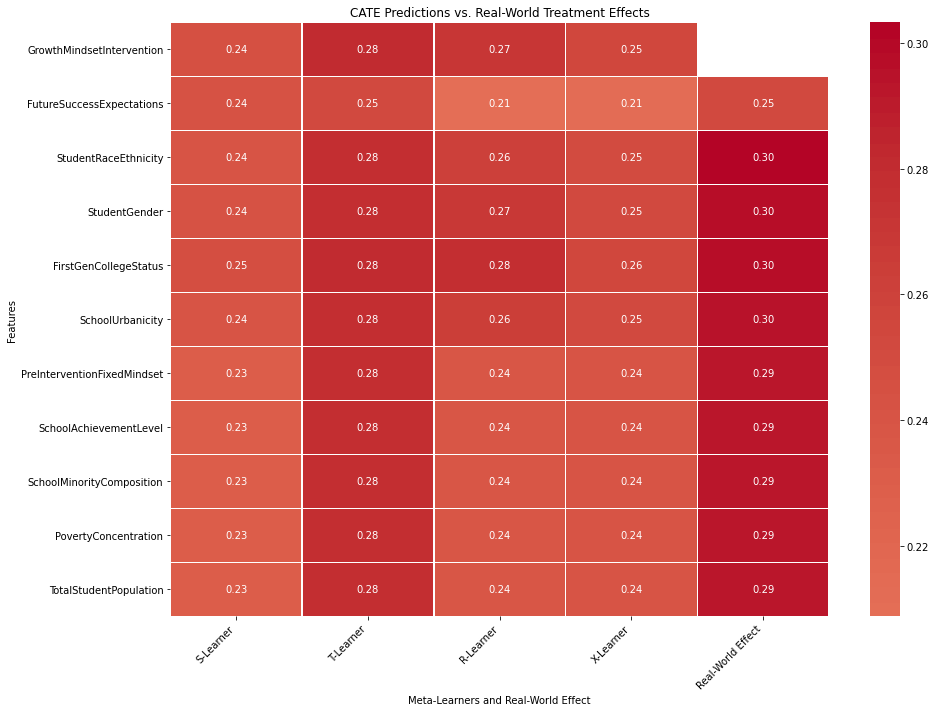

In [23]:
# Create a new DataFrame to compare the predicted CATE with real-world treatment effects
comparison_matrix_with_real = pd.DataFrame(index=features, columns=['S-Learner', 'T-Learner', 'R-Learner', 'X-Learner', 'Real-World Effect'])

# Fill the matrix with the predicted CATE values and real-world treatment effects
for feature in features:
    for learner in ['S-Learner', 'T-Learner', 'R-Learner', 'X-Learner']:
        learner_data = cate_results[feature]
        mean_cate = learner_data[learner_data['Learner'] == learner]['CATE'].mean()
        comparison_matrix_with_real.loc[feature, learner] = mean_cate
        
    # Fill in the real-world effect for the feature
    comparison_matrix_with_real.loc[feature, 'Real-World Effect'] = real_world_effects[feature].mean()

# Display the updated comparison matrix
print(comparison_matrix_with_real)

# Visualize the Comparison
plt.figure(figsize=(14, 10))

# Heatmap showing both CATE predictions and real-world effects
sns.heatmap(comparison_matrix_with_real.astype(float), annot=True, cmap="coolwarm", center=0, cbar=True, fmt=".2f", linewidths=.5)

plt.title('CATE Predictions vs. Real-World Treatment Effects')
plt.xlabel('Meta-Learners and Real-World Effect')
plt.ylabel('Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()

# Handling NaN Values and Recalculating Real-World Effects
Purpose: Resolve NaN values in the real-world effects by manually recalculating the mean scores for treated and control groups.

In [24]:
# Step 1: Check for missing values in the relevant columns
missing_values = combined_data[['GrowthMindsetIntervention', 'StudentAchievementScore']].isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 GrowthMindsetIntervention    0
StudentAchievementScore      0
dtype: int64


In [25]:
# Step 2: Inspect data for GrowthMindsetIntervention to see if treated or control group has insufficient data
print("\nData distribution for GrowthMindsetIntervention:")
print(combined_data['GrowthMindsetIntervention'].value_counts())


Data distribution for GrowthMindsetIntervention:
0    28028
1    13536
Name: GrowthMindsetIntervention, dtype: int64


In [26]:
# Step 3: Investigate the distribution of StudentAchievementScore for treated and control groups
treated_scores = combined_data[combined_data['GrowthMindsetIntervention'] == 1]['StudentAchievementScore']
control_scores = combined_data[combined_data['GrowthMindsetIntervention'] == 0]['StudentAchievementScore']

In [27]:
print("\nTreated group scores (first few rows):")
print(treated_scores.head())

print("\nControl group scores (first few rows):")
print(control_scores.head())


Treated group scores (first few rows):
0    0.081602
1   -0.385869
2    0.398184
3   -0.175037
4    0.884583
Name: StudentAchievementScore, dtype: float64

Control group scores (first few rows):
3384   -1.434893
3385    0.999290
3386    0.197742
3387   -0.059160
3388   -0.041489
Name: StudentAchievementScore, dtype: float64


In [28]:
# Manually calculate the mean scores for treated and control groups
mean_treated_score = treated_scores.mean()
mean_control_score = control_scores.mean()

# Calculate the real-world effect
real_world_effect_growth_mindset = mean_treated_score - mean_control_score
print("\nManually Recalculated Real-World Effect for GrowthMindsetIntervention:", real_world_effect_growth_mindset)


Manually Recalculated Real-World Effect for GrowthMindsetIntervention: 0.3036748422490185


In [29]:
# Update the comparison matrix with the manually recalculated real-world effect
comparison_matrix_with_real.loc['GrowthMindsetIntervention', 'Real-World Effect'] = real_world_effect_growth_mindset

# Display the updated comparison matrix
print("\nUpdated comparison matrix with recalculated Real-World Effect:")
print(comparison_matrix_with_real)


Updated comparison matrix with recalculated Real-World Effect:
                            S-Learner T-Learner R-Learner X-Learner  \
GrowthMindsetIntervention    0.244798  0.279892  0.270576  0.253454   
FutureSuccessExpectations    0.243297  0.252234  0.208768  0.212314   
StudentRaceEthnicity         0.240382  0.278262    0.2606  0.248819   
StudentGender                0.243489  0.279347  0.267875  0.251988   
FirstGenCollegeStatus        0.246866  0.280338  0.277363  0.255865   
SchoolUrbanicity             0.240176  0.278914  0.263373  0.251655   
PreInterventionFixedMindset  0.230647  0.278851  0.238911  0.240691   
SchoolAchievementLevel       0.230647  0.278851  0.238911  0.240691   
SchoolMinorityComposition    0.230647  0.278851  0.238911  0.240691   
PovertyConcentration         0.230647  0.278851  0.238911  0.240691   
TotalStudentPopulation       0.230647  0.278851  0.238911  0.240691   

                            Real-World Effect  
GrowthMindsetIntervention          

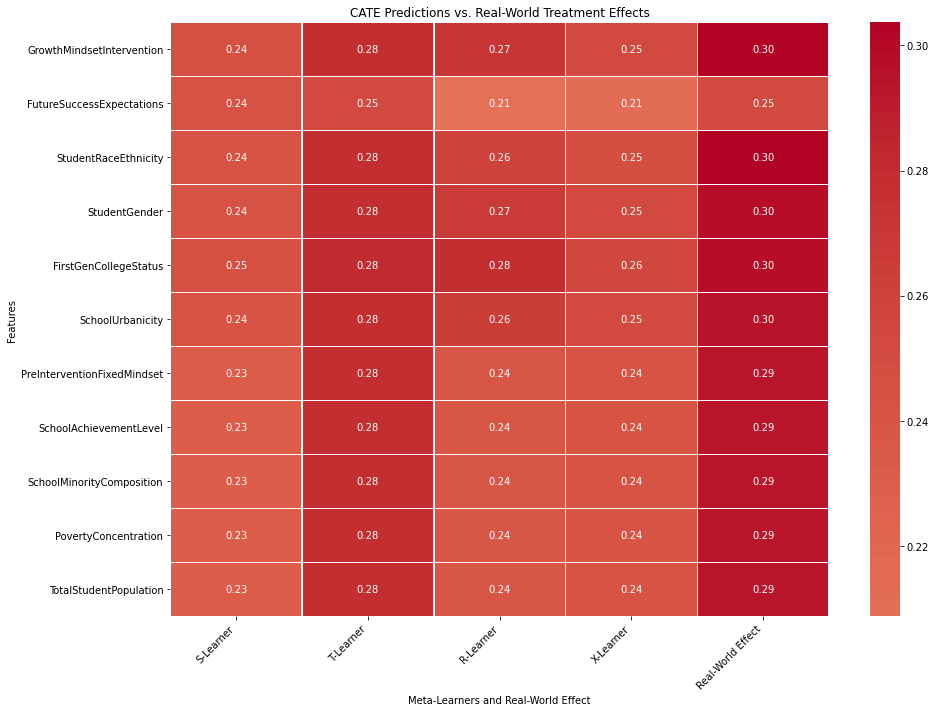

In [30]:
# Visualize the Comparison
plt.figure(figsize=(14, 10))

# Heatmap showing both CATE predictions and real-world effects
sns.heatmap(comparison_matrix_with_real.astype(float), annot=True, cmap="coolwarm", center=0, cbar=True, fmt=".2f", linewidths=.5)

plt.title('CATE Predictions vs. Real-World Treatment Effects')
plt.xlabel('Meta-Learners and Real-World Effect')
plt.ylabel('Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()

# Comparative Analysis of Meta-Learners
Purpose: Evaluate the accuracy of each meta-learner by comparing their predicted CATE values with the real-world effects, and identify the best-performing learner for each feature.


Best Learner for each feature:
                            S-Learner T-Learner R-Learner X-Learner  \
GrowthMindsetIntervention    0.244798  0.279892  0.270576  0.253454   
FutureSuccessExpectations    0.243297  0.252234  0.208768  0.212314   
StudentRaceEthnicity         0.240382  0.278262    0.2606  0.248819   
StudentGender                0.243489  0.279347  0.267875  0.251988   
FirstGenCollegeStatus        0.246866  0.280338  0.277363  0.255865   
SchoolUrbanicity             0.240176  0.278914  0.263373  0.251655   
PreInterventionFixedMindset  0.230647  0.278851  0.238911  0.240691   
SchoolAchievementLevel       0.230647  0.278851  0.238911  0.240691   
SchoolMinorityComposition    0.230647  0.278851  0.238911  0.240691   
PovertyConcentration         0.230647  0.278851  0.238911  0.240691   
TotalStudentPopulation       0.230647  0.278851  0.238911  0.240691   

                            Real-World Effect     Best Learner  
GrowthMindsetIntervention            0.303675  T-L

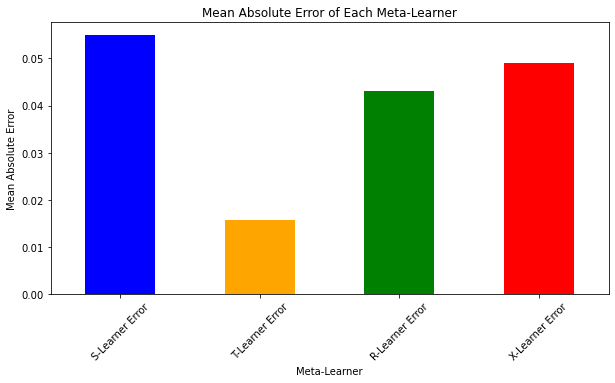


Updated comparison matrix with error calculations:
                            S-Learner T-Learner R-Learner X-Learner  \
GrowthMindsetIntervention    0.244798  0.279892  0.270576  0.253454   
FutureSuccessExpectations    0.243297  0.252234  0.208768  0.212314   
StudentRaceEthnicity         0.240382  0.278262    0.2606  0.248819   
StudentGender                0.243489  0.279347  0.267875  0.251988   
FirstGenCollegeStatus        0.246866  0.280338  0.277363  0.255865   
SchoolUrbanicity             0.240176  0.278914  0.263373  0.251655   
PreInterventionFixedMindset  0.230647  0.278851  0.238911  0.240691   
SchoolAchievementLevel       0.230647  0.278851  0.238911  0.240691   
SchoolMinorityComposition    0.230647  0.278851  0.238911  0.240691   
PovertyConcentration         0.230647  0.278851  0.238911  0.240691   
TotalStudentPopulation       0.230647  0.278851  0.238911  0.240691   

                            Real-World Effect  S-Learner Error  \
GrowthMindsetIntervention    

In [35]:
import numpy as np
import pandas as pd

# Calculate the absolute error for each learner
comparison_matrix_with_real['S-Learner Error'] = abs(comparison_matrix_with_real['S-Learner'] - comparison_matrix_with_real['Real-World Effect'])
comparison_matrix_with_real['T-Learner Error'] = abs(comparison_matrix_with_real['T-Learner'] - comparison_matrix_with_real['Real-World Effect'])
comparison_matrix_with_real['R-Learner Error'] = abs(comparison_matrix_with_real['R-Learner'] - comparison_matrix_with_real['Real-World Effect'])
comparison_matrix_with_real['X-Learner Error'] = abs(comparison_matrix_with_real['X-Learner'] - comparison_matrix_with_real['Real-World Effect'])

# Ensure all errors are numeric and handle NaN values by filling them with a large number (infinity)
comparison_matrix_with_real['S-Learner Error'] = pd.to_numeric(comparison_matrix_with_real['S-Learner Error'], errors='coerce').fillna(np.inf)
comparison_matrix_with_real['T-Learner Error'] = pd.to_numeric(comparison_matrix_with_real['T-Learner Error'], errors='coerce').fillna(np.inf)
comparison_matrix_with_real['R-Learner Error'] = pd.to_numeric(comparison_matrix_with_real['R-Learner Error'], errors='coerce').fillna(np.inf)
comparison_matrix_with_real['X-Learner Error'] = pd.to_numeric(comparison_matrix_with_real['X-Learner Error'], errors='coerce').fillna(np.inf)

# Identify the best learner for each feature by finding the minimum error
comparison_matrix_with_real['Best Learner'] = comparison_matrix_with_real[['S-Learner Error', 'T-Learner Error', 'R-Learner Error', 'X-Learner Error']].idxmin(axis=1)

print("\nBest Learner for each feature:")
print(comparison_matrix_with_real[['S-Learner', 'T-Learner', 'R-Learner', 'X-Learner', 'Real-World Effect', 'Best Learner']])

# Visualize the results using bar plots
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
mean_errors = comparison_matrix_with_real[['S-Learner Error', 'T-Learner Error', 'R-Learner Error', 'X-Learner Error']].mean()
mean_errors.plot(kind='bar', color=['blue', 'orange', 'green', 'red'])
plt.title('Mean Absolute Error of Each Meta-Learner')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Meta-Learner')
plt.xticks(rotation=45)
plt.show()

# Display the updated comparison matrix with error calculations
print("\nUpdated comparison matrix with error calculations:")
print(comparison_matrix_with_real)


# Summary of the Results:
Best Learner Identification: The Best Learner column in the final matrix shows which meta-learner most accurately predicted the real-world effects for each feature based on the smallest absolute error.
T-Learner Performance: The T-Learner consistently appears as the best performer across multiple features, indicating it may be the most accurate model in this scenario.

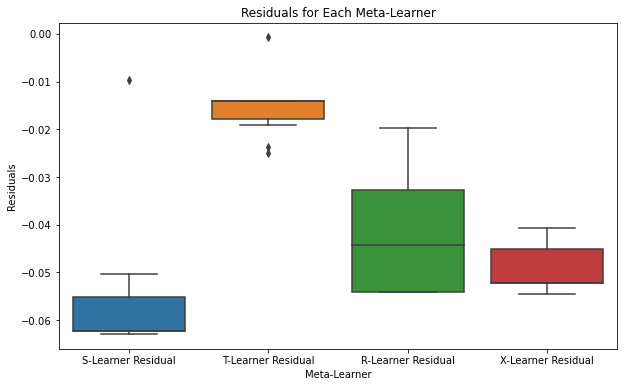

In [36]:
# Calculate residuals for each meta-learner
comparison_matrix_with_real['S-Learner Residual'] = comparison_matrix_with_real['S-Learner'] - comparison_matrix_with_real['Real-World Effect']
comparison_matrix_with_real['T-Learner Residual'] = comparison_matrix_with_real['T-Learner'] - comparison_matrix_with_real['Real-World Effect']
comparison_matrix_with_real['R-Learner Residual'] = comparison_matrix_with_real['R-Learner'] - comparison_matrix_with_real['Real-World Effect']
comparison_matrix_with_real['X-Learner Residual'] = comparison_matrix_with_real['X-Learner'] - comparison_matrix_with_real['Real-World Effect']

# Plot residuals to check for patterns
plt.figure(figsize=(10, 6))
sns.boxplot(data=comparison_matrix_with_real[['S-Learner Residual', 'T-Learner Residual', 'R-Learner Residual', 'X-Learner Residual']])
plt.title('Residuals for Each Meta-Learner')
plt.ylabel('Residuals')
plt.xlabel('Meta-Learner')
plt.show()


NameError: name 'model_slearner' is not defined